In [1]:
# !pip install imblearn
# !pip install gensim

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

Read Dataset

In [3]:
df = pd.read_csv("Job titles and industries.csv")
print("The shape of dataset is {}.\n\n".format(df.shape))
df.head()

The shape of dataset is (8586, 2).




,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


# EDA

In [4]:
df.info()
# from here we found that data doesnot contains nulls (each column has 8586 record)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [5]:
df.describe()
# from here we explore more about the data, frequency, Most frequent values, how many unique values are there 

,job title,industry
count,8586,8586
unique,3890,4
top,marketing executive,IT
freq,91,4746


<AxesSubplot:>

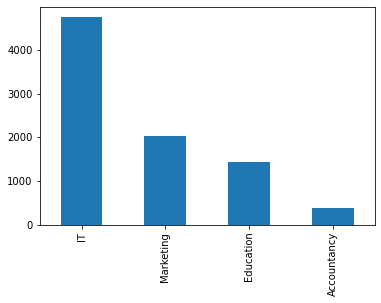

In [6]:
df["industry"].value_counts().plot.bar()
# imbalanced data

In [7]:
#percentage of each category 
df["industry"].value_counts() / df.shape[0] 

IT             0.552760
Marketing      0.236548
Education      0.167133
Accountancy    0.043559
Name: industry, dtype: float64

In [8]:
df.duplicated().sum()
# more than half of the dataset are duplicated data 

4618

# Data preprocessing 

In [9]:
# Drop duplicates
df.drop_duplicates(inplace=True, ignore_index=True)
print("The shape of dataset after removing duplicates: {}.\n\n".format(df.shape))

The shape of dataset after removing duplicates: (3968, 2).




In [10]:
# check data imbalance after removing duplicates
df["industry"].value_counts() / df.shape[0] 
# Data is still so imbalnced (but it is better since percentage of records for IT became closer to Marketing than before )
# and percentage of (Marketing, Education, Accountancy) become larger and closer to IT than before 

IT             0.385333
Marketing      0.303175
Education      0.245212
Accountancy    0.066280
Name: industry, dtype: float64

In [11]:
# Encode target
df_enc = df.copy()
ord_enc = preprocessing.OrdinalEncoder(dtype=int)
df_enc["industry"] = pd.DataFrame(ord_enc.fit_transform(df[["industry"]]))
df_enc["industry"].value_counts()

2    1529
3    1203
1     973
0     263
Name: industry, dtype: int64

In [12]:
#Save encoding object to use it in api 
pickle.dump(ord_enc,open("enc.pkl","wb"))

In [13]:
cleanframe = df_enc.copy()
def clean_text(text):
    """
        text: a string 
        return: modified clean string
    """
    result = ""
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) >= 2:
            token = token.lower() # lowercase text
            result+=token+" "     # append to result
    return result

cleanframe['job title'] = cleanframe['job title'].map(clean_text)
cleanframe.head()

,job title,industry
0,technical support helpdesk supervisor county b...,2
1,senior technical support engineer,2
2,head services,2
3,js end engineer,2
4,network telephony controller,2


In [14]:
# split the data to Train and Test
X, y = cleanframe['job title'], cleanframe['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [15]:
# Convert a collection of text documents to a matrix of token counts
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [16]:
#Save vectorizer.vocabulary_ to use it in api 
pickle.dump(vect.vocabulary_,open("feature.pkl","wb"))

In [17]:
# Transform a count matrix to a normalized tf or tf-idf representation
tfidf = TfidfTransformer(sublinear_tf=True, norm='l2' )
tfidf = tfidf.fit(X_train)
X_train = tfidf.transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [18]:
#Save tfidf to use it in api 
pickle.dump(tfidf, open("tfidf.pkl", "wb"))

In [19]:
# # Scale the data using robust scaling
# rb_scaler = preprocessing.RobustScaler()
# X_train = rb_scaler.fit_transform(X_train)
# X_test = rb_scaler.transform(X_test)

In [20]:
# Handle imbalance using oversampling
sm = SMOTE(sampling_strategy="minority", random_state=0)
X_oversampled , y_oversampled = sm.fit_resample(X_train,y_train)

# Model Training

Naive Bayes classifier

In [21]:
clf = MultinomialNB().fit(X_oversampled , y_oversampled)

In [22]:
print("Score for train data = ", clf.score(X_train , y_train))
print("Score for test  data = ", clf.score(X_test, y_test))

Score for train data =  0.9017013232514177
Score for test  data =  0.8841309823677582


              precision    recall  f1-score   support

           0       0.95      0.65      0.77        85
           1       0.87      0.97      0.92       169
           2       0.89      0.90      0.90       304
           3       0.87      0.88      0.87       236

    accuracy                           0.88       794
   macro avg       0.90      0.85      0.87       794
weighted avg       0.89      0.88      0.88       794

----------------confusion matrix------------


<AxesSubplot:>

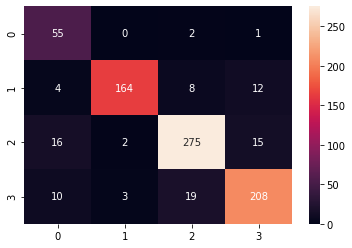

In [23]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))
print("----------------confusion matrix------------")
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, annot=True, fmt='d')

Logisistic Regression

In [24]:
clf_log_reg = LogisticRegressionCV(solver="newton-cg", cv=5).fit(X_oversampled , y_oversampled)

In [25]:
print("Score for train data = ", clf_log_reg.score(X_train , y_train))
print("Score for test  data = ", clf_log_reg.score(X_test, y_test))

Score for train data =  0.9417139256458728
Score for test  data =  0.8954659949622166


              precision    recall  f1-score   support

           0       0.95      0.82      0.88        67
           1       0.90      0.92      0.91       184
           2       0.91      0.91      0.91       310
           3       0.85      0.88      0.87       233

    accuracy                           0.90       794
   macro avg       0.90      0.88      0.89       794
weighted avg       0.90      0.90      0.90       794

----------------confusion matrix------------


<AxesSubplot:>

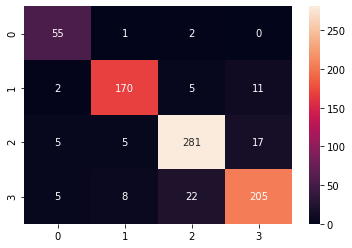

In [26]:
y_pred = clf_log_reg.predict(X_test)
print(classification_report(y_pred, y_test))
print("----------------confusion matrix------------")
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, annot=True, fmt='d')

SVM

In [27]:
clf = SGDClassifier().fit(X_oversampled , y_oversampled)

In [28]:
print("Score for train data = ", clf.score(X_train , y_train))
print("Score for test  data = ", clf.score(X_test, y_test))

Score for train data =  0.941398865784499
Score for test  data =  0.8866498740554156


              precision    recall  f1-score   support

           0       0.95      0.79      0.86        70
           1       0.89      0.94      0.92       179
           2       0.89      0.90      0.90       306
           3       0.86      0.86      0.86       239

    accuracy                           0.89       794
   macro avg       0.90      0.87      0.88       794
weighted avg       0.89      0.89      0.89       794

----------------confusion matrix------------


<AxesSubplot:>

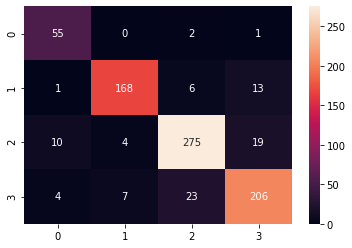

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))
print("----------------confusion matrix------------")
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, annot=True, fmt='d')

RandomForest

In [34]:
clf = RandomForestClassifier(max_depth=30).fit(X_oversampled , y_oversampled)

In [35]:
print("Score for train data = ", clf.score(X_train , y_train))
print("Score for test  data = ", clf.score(X_test, y_test))

Score for train data =  0.868935097668557
Score for test  data =  0.8312342569269522


              precision    recall  f1-score   support

           0       0.81      0.76      0.78        62
           1       0.76      0.97      0.85       146
           2       0.94      0.76      0.84       381
           3       0.76      0.89      0.82       205

    accuracy                           0.83       794
   macro avg       0.82      0.84      0.82       794
weighted avg       0.85      0.83      0.83       794

----------------confusion matrix------------


<AxesSubplot:>

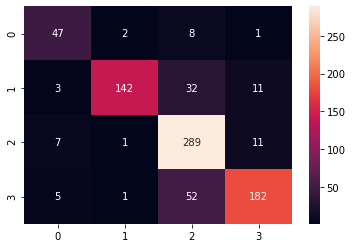

In [36]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))
print("----------------confusion matrix------------")
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, annot=True, fmt='d')

# Choose Logistic Regression

In [37]:
# Saving model to disk
pickle.dump(clf_log_reg, open('model.pkl','wb'))